In [1]:
from pylab import *
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Polygon
import scipy.constants as cst
from astropy.io import ascii, fits
from scipy.signal.signaltools import wiener
from astropy.convolution import Gaussian1DKernel, convolve

fig_width_pt = 469.75499                # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width * golden_mean * 1.1   # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'pdf',
          'axes.linewidth': 1.5,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.labelsize': 16,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'lines.dash_joinstyle' : 'round',
          'lines.dash_capstyle' : 'round',
          'lines.solid_joinstyle' : 'round',
          'lines.solid_capstyle' : 'round',
          'text.usetex': False,
          'mathtext.fontset' : 'stixsans',
          'mathtext.default' : 'rm',
          'xtick.direction' : 'in',
          'ytick.direction' : 'in',
          'xtick.top' : False,
          'ytick.right' : False,
          'figure.figsize': fig_size}
rcParams.update(params)

In [2]:
import scipy.integrate as integrate

def lum_distance(z):
    
    omega_m = .315
    omega_lam = .685
    H_0 = 69.8/(3.09*10**19)
    c = 3*10**8
    D_H = c/H_0
    D_M = D_H*integrate.quad(lambda t: 1/np.sqrt(omega_m*(1+t)**3 + omega_lam), 0, z)[0]
    D_L = (1+z)*D_M
    
    return D_L

def luminosity_calc(flux, lum_dist):
    return 4*np.pi*(lum_dist**2)*(flux)*10**(-17+4-7)

In [3]:
rootdir_CLIF = "/Users/thepoetoftwilight/Documents/SDSS/CLIFs/"

In [4]:
import pandas as pd

In [5]:
astro_df_CLIF = pd.read_csv(rootdir_CLIF + "pipeline_astrometry.csv")
spectral_pipeline_df_CLIF = pd.read_csv(rootdir_CLIF + "pipeline_emission.csv")
spectral_custom_df_CLIF = pd.read_csv(rootdir_CLIF + "custom_emission.csv")
x_ray_df_CLIF = pd.read_csv(rootdir_CLIF + "x_ray.csv")

In [6]:
from functools import reduce

In [7]:
df_CLIF_raw = [astro_df_CLIF, spectral_pipeline_df_CLIF, spectral_custom_df_CLIF, x_ray_df_CLIF]
df_CLIF = reduce(lambda left,right: pd.merge(left,right,on='Common Name'), df_CLIF_raw)
df_CLIF = df_CLIF.replace(0, np.nan)

In [8]:
df_CLIF['D_L'] = np.array([lum_distance(z) for z in df_CLIF['z']])
df_CLIF['[O_III] 5007 Luminosity'] = luminosity_calc(df_CLIF['[O_III] 5007 Flux'], df_CLIF['D_L'])
df_CLIF['2-10 keV Luminosity'] = luminosity_calc(df_CLIF['2-10 keV Flux'], df_CLIF['D_L'])

In [9]:
sig_ratio_c = 2
sig_ratio_l = 2

In [10]:
df_CLIF.columns

Index(['Common Name', 'Object', 'RA', 'Dec', 'z', 'H_alpha Flux', 'H_alpha EW',
       'H_beta Flux', 'H_beta EW', '[O_III] 5007 Flux', '[O_III] 5007 EW',
       'C_III] 1908 Flux', 'C_III] 1908 EW', 'He_II 4685 Flux',
       'He_II 4685 EW', '[Ne_III] 3868 Flux', '[Ne_III] 3868 EW',
       '[N_II] 6583 Flux', '[N_II] 6583 EW', '[Ne_V] 3425 Flux',
       '[Ne_V] 3425 EW', '[Ne_V] 3425 SNR_L', '[Ne_V] 3425 SNR_C',
       '[Fe_VII] 5721 Flux', '[Fe_VII] 5721 EW', '[Fe_VII] 5721 SNR_L',
       '[Fe_VII] 5721 SNR_C', '[Fe_VII] 6087 Flux', '[Fe_VII] 6087 EW',
       '[Fe_VII] 6087 SNR_L', '[Fe_VII] 6087 SNR_C', '2-10 keV Flux', 'D_L',
       '[O_III] 5007 Luminosity', '2-10 keV Luminosity'],
      dtype='object')

In [11]:
df_CLIF['[Ne_V] 3425 Detection'] = np.zeros(len(df_CLIF)) 
df_CLIF['[Fe_VII] 5721 Detection'] = np.zeros(len(df_CLIF)) 
df_CLIF['[Fe_VII] 6087 Detection'] = np.zeros(len(df_CLIF))

In [12]:
df_CLIF.loc[(df_CLIF['[Ne_V] 3425 SNR_C']>sig_ratio_c)&(df_CLIF['[Ne_V] 3425 SNR_L']>sig_ratio_l), ['[Ne_V] 3425 Detection']] = 2
df_CLIF.loc[(df_CLIF['[Ne_V] 3425 SNR_C']>sig_ratio_c)&(df_CLIF['[Ne_V] 3425 SNR_L']<sig_ratio_l), ['[Ne_V] 3425 Detection']] = 1

df_CLIF.loc[(df_CLIF['[Fe_VII] 5721 SNR_C']>sig_ratio_c)&(df_CLIF['[Fe_VII] 5721 SNR_L']>sig_ratio_l), ['[Fe_VII] 5721 Detection']] = 2
df_CLIF.loc[(df_CLIF['[Fe_VII] 5721 SNR_C']>sig_ratio_c)&(df_CLIF['[Fe_VII] 5721 SNR_L']<sig_ratio_l), ['[Fe_VII] 5721 Detection']] = 1

df_CLIF.loc[(df_CLIF['[Fe_VII] 6087 SNR_C']>sig_ratio_c)&(df_CLIF['[Fe_VII] 6087 SNR_L']>sig_ratio_l), ['[Fe_VII] 6087 Detection']] = 2
df_CLIF.loc[(df_CLIF['[Fe_VII] 6087 SNR_C']>sig_ratio_c)&(df_CLIF['[Fe_VII] 6087 SNR_L']<sig_ratio_l), ['[Fe_VII] 6087 Detection']] = 1

In [13]:
df_CLIF['[Ne_V] 3425 Delta_Flux'] = df_CLIF['[Ne_V] 3425 Flux']/df_CLIF['[Ne_V] 3425 SNR_L']
df_CLIF['[Fe_VII] 5721 Delta_Flux'] = df_CLIF['[Fe_VII] 5721 Flux']/ df_CLIF['[Fe_VII] 5721 SNR_L']
df_CLIF['[Fe_VII] 6087 Delta_Flux'] = df_CLIF['[Fe_VII] 6087 Flux']/df_CLIF['[Fe_VII] 6087 SNR_L']

In [14]:
df_CLIF.loc[df_CLIF['[Ne_V] 3425 Detection'] == 0, ['[Ne_V] 3425 Flux', '[Ne_V] 3425 EW']] = [np.nan, np.nan]
df_CLIF.loc[df_CLIF['[Fe_VII] 5721 Detection'] == 0, ['[Fe_VII] 5721 Flux', '[Fe_VII] 5721 EW']] = [np.nan, np.nan]
df_CLIF.loc[df_CLIF['[Fe_VII] 6087 Detection'] == 0, ['[Fe_VII] 6087 Flux', '[Fe_VII] 6087 EW']] = [np.nan, np.nan]

In [15]:
df_CLIF.loc[df_CLIF['[Ne_V] 3425 Detection'] == 1, ['[Ne_V] 3425 EW']] = sig_ratio_l*df_CLIF['[Ne_V] 3425 EW']*df_CLIF['[Ne_V] 3425 Delta_Flux']/df_CLIF['[Ne_V] 3425 Flux']
df_CLIF.loc[df_CLIF['[Ne_V] 3425 Detection'] == 1, ['[Ne_V] 3425 Flux']] = sig_ratio_l*df_CLIF['[Ne_V] 3425 Delta_Flux']

df_CLIF.loc[df_CLIF['[Fe_VII] 5721 Detection'] == 1, ['[Fe_VII] 5721 EW']] = sig_ratio_l*df_CLIF['[Fe_VII] 5721 EW']*df_CLIF['[Fe_VII] 5721 Delta_Flux']/df_CLIF['[Fe_VII] 5721 Flux']
df_CLIF.loc[df_CLIF['[Fe_VII] 5721 Detection'] == 1, ['[Fe_VII] 5721 Flux']] = sig_ratio_l*df_CLIF['[Fe_VII] 5721 Delta_Flux']

df_CLIF.loc[df_CLIF['[Fe_VII] 6087 Detection'] == 1, ['[Fe_VII] 6087 EW']] = sig_ratio_l*df_CLIF['[Fe_VII] 6087 EW']*df_CLIF['[Fe_VII] 6087 Delta_Flux']/df_CLIF['[Fe_VII] 6087 Flux']
df_CLIF.loc[df_CLIF['[Fe_VII] 6087 Detection'] == 1, ['[Fe_VII] 6087 Flux']] = sig_ratio_l*df_CLIF['[Fe_VII] 6087 Delta_Flux']

In [16]:
df_CLIF

,Common Name,Object,RA,Dec,z,H_alpha Flux,H_alpha EW,H_beta Flux,H_beta EW,[O_III] 5007 Flux,...,2-10 keV Flux,D_L,[O_III] 5007 Luminosity,2-10 keV Luminosity,[Ne_V] 3425 Detection,[Fe_VII] 5721 Detection,[Fe_VII] 6087 Detection,[Ne_V] 3425 Delta_Flux,[Fe_VII] 5721 Delta_Flux,[Fe_VII] 6087 Delta_Flux
0,J1031+26,spec-6457-56330-0414,"hms_tuple(h=10.0, m=31.0, s=9.53520000000566)","dms_tuple(d=26.0, m=15.0, s=34.02359999999476)",0.252290,766.9597,148.692550,95.23881,18.102041,893.02277,...,NaN,3.937636e+25,1.739977e+35,NaN,2.0,2.0,2.0,4.490112,1.799107,2.150870
1,J1641+43,spec-0628-52083-0526,"hms_tuple(h=16.0, m=41.0, s=26.911200000008648)","dms_tuple(d=43.0, m=21.0, s=21.610800000004247)",0.221039,1215.8800,166.000000,226.00000,35.000000,1200.06000,...,NaN,3.391578e+25,1.734668e+35,NaN,2.0,2.0,2.0,12.697600,3.702481,9.353860
2,J1241+44,spec-1372-53062-0072,"hms_tuple(h=12.0, m=41.0, s=34.252800000005266)","dms_tuple(d=44.0, m=26.0, s=39.24240000000566)",0.041901,315.4560,30.500000,49.60000,5.100000,215.26400,...,NaN,5.740076e+24,8.912849e+32,NaN,0.0,2.0,2.0,NaN,7.297894,4.843313
3,III Zw 77,spec-1171-52753-0076,"hms_tuple(h=16.0, m=23.0, s=45.88560000001081)","dms_tuple(d=41.0, m=4.0, s=56.39879999999437)",0.033103,10458.0000,81.500000,2520.00000,15.400000,14666.40000,...,40000.0,4.506138e+24,3.742332e+34,1.020654e+35,0.0,2.0,2.0,NaN,23.479579,16.104909
4,Mrk 1388,spec-2144-53770-0491,"hms_tuple(h=14.0, m=50.0, s=37.852800000010944)","dms_tuple(d=22.0, m=44.0, s=3.613200000000063)",0.020954,1046.7500,121.100000,265.00000,30.800000,2271.05000,...,2500.0,2.827117e+24,2.280994e+33,2.510947e+33,0.0,2.0,2.0,NaN,34.958424,20.174544
5,Q1131+16,NaN,"hms_tuple(h=11.0, m=31.0, s=11.05)","dms_tuple(d=16.0, m=27.0, s=39.50)",0.173200,2368.5780,296.072250,474.00000,59.250000,2497.98000,...,NaN,2.585353e+25,2.098159e+35,NaN,2.0,2.0,2.0,0.000498,0.000151,0.000235
6,ESO 138 G1,NaN,"hms_tuple(h=16.0, m=51.0, s=20.13)","dms_tuple(d=-59.0, m=14.0, s=05.20)",0.009100,43775.0000,35.088787,10300.00000,8.240000,92700.00000,...,180000.0,1.216924e+24,1.725110e+34,3.349728e+34,2.0,2.0,2.0,0.018500,0.001257,0.002470
7,Tololo 0109-383,NaN,"hms_tuple(h=01.0, m=11.0, s=27.63)","dms_tuple(d=-38.0, m=05.0, s=00.48)",0.011800,28204.0000,154.693395,6440.00000,58.915497,2405.60000,...,120000.0,1.581197e+24,7.557967e+32,3.770186e+34,2.0,2.0,2.0,0.003650,0.000832,0.001790
8,J0717+37,NaN,"hms_tuple(h=07.0, m=17.0, s=35.00)","dms_tuple(d=-37.0, m=45.0, s=42.00)",1.688000,NaN,NaN,4.16000,3.700000,55.86000,...,1000.0,3.867337e+26,1.049868e+36,1.879464e+37,2.0,2.0,2.0,0.000008,0.000002,0.000003


In [17]:
rootdir_QSO = "/Users/thepoetoftwilight/Documents/SDSS/QSO-Data/"

In [18]:
astro_df_QSO = pd.read_csv(rootdir_QSO + "pipeline_astrometry.csv")
spectral_pipeline_df_QSO = pd.read_csv(rootdir_QSO + "pipeline_emission.csv")
spectral_custom_df_QSO = pd.read_csv(rootdir_QSO + "custom_emission.csv")

In [19]:
df_QSO_raw = [astro_df_QSO, spectral_pipeline_df_QSO, spectral_custom_df_QSO]
df_QSO = reduce(lambda left,right: pd.merge(left,right,on='Object'), df_QSO_raw)
df_QSO = df_QSO.replace(0, np.nan)

In [20]:
df_QSO['D_L'] = np.array([lum_distance(z) for z in df_QSO['z']])
df_QSO['[O_III] 5007 Luminosity'] = luminosity_calc(df_QSO['[O_III] 5007 Flux'], df_QSO['D_L'])

In [21]:
df_QSO['[Ne_V] 3425 Detection'] = np.zeros(len(df_QSO)) 
df_QSO['[Fe_VII] 5721 Detection'] = np.zeros(len(df_QSO)) 
df_QSO['[Fe_VII] 6087 Detection'] = np.zeros(len(df_QSO))

In [22]:
df_QSO.loc[(df_QSO['[Ne_V] 3425 SNR_C']>sig_ratio_c)&(df_QSO['[Ne_V] 3425 SNR_L']>sig_ratio_l), ['[Ne_V] 3425 Detection']] = 2
df_QSO.loc[(df_QSO['[Ne_V] 3425 SNR_C']>sig_ratio_c)&(df_QSO['[Ne_V] 3425 SNR_L']<sig_ratio_l), ['[Ne_V] 3425 Detection']] = 1

df_QSO.loc[(df_QSO['[Fe_VII] 5721 SNR_C']>sig_ratio_c)&(df_QSO['[Fe_VII] 5721 SNR_L']>sig_ratio_l), ['[Fe_VII] 5721 Detection']] = 2
df_QSO.loc[(df_QSO['[Fe_VII] 5721 SNR_C']>sig_ratio_c)&(df_QSO['[Fe_VII] 5721 SNR_L']<sig_ratio_l), ['[Fe_VII] 5721 Detection']] = 1

df_QSO.loc[(df_QSO['[Fe_VII] 6087 SNR_C']>sig_ratio_c)&(df_QSO['[Fe_VII] 6087 SNR_L']>sig_ratio_l), ['[Fe_VII] 6087 Detection']] = 2
df_QSO.loc[(df_QSO['[Fe_VII] 6087 SNR_C']>sig_ratio_c)&(df_QSO['[Fe_VII] 6087 SNR_L']<sig_ratio_l), ['[Fe_VII] 6087 Detection']] = 1

In [23]:
df_QSO['[Ne_V] 3425 Delta_Flux'] = df_QSO['[Ne_V] 3425 Flux']/df_QSO['[Ne_V] 3425 SNR_L']
df_QSO['[Fe_VII] 5721 Delta_Flux'] = df_QSO['[Fe_VII] 5721 Flux']/ df_QSO['[Fe_VII] 5721 SNR_L']
df_QSO['[Fe_VII] 6087 Delta_Flux'] = df_QSO['[Fe_VII] 6087 Flux']/df_QSO['[Fe_VII] 6087 SNR_L']

In [24]:
df_QSO

,Object,RA,Dec,z,H_alpha Flux,H_alpha EW,H_beta Flux,H_beta EW,[O_III] 5007 Flux,[O_III] 5007 EW,...,[Fe_VII] 6087 SNR_L,[Fe_VII] 6087 SNR_C,D_L,[O_III] 5007 Luminosity,[Ne_V] 3425 Detection,[Fe_VII] 5721 Detection,[Fe_VII] 6087 Detection,[Ne_V] 3425 Delta_Flux,[Fe_VII] 5721 Delta_Flux,[Fe_VII] 6087 Delta_Flux
0,spec-0266-51602-0009,"hms_tuple(h=9.0, m=47.0, s=45.26640000000867)","dms_tuple(d=-0.0, m=-41.0, s=-13.242984000000035)",2.830591,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.246513e+26,NaN,0.0,0.0,0.0,NaN,NaN,NaN
1,spec-0266-51602-0042,"hms_tuple(h=9.0, m=45.0, s=5.932800000004335)","dms_tuple(d=-0.0, m=-46.0, s=-44.92966800000005)",2.297970,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.633701e+26,NaN,0.0,0.0,0.0,NaN,NaN,NaN
2,spec-0266-51602-0050,"hms_tuple(h=9.0, m=45.0, s=32.68080000000211)","dms_tuple(d=-1.0, m=-0.0, s=-3.349799999999803)",3.036635,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.884271e+26,NaN,0.0,0.0,0.0,NaN,NaN,NaN
3,spec-0266-51602-0088,"hms_tuple(h=9.0, m=44.0, s=54.242400000007365)","dms_tuple(d=-0.0, m=-43.0, s=-30.355499999999864)",2.287936,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.603874e+26,NaN,0.0,0.0,0.0,NaN,NaN,NaN
4,spec-0266-51602-0133,"hms_tuple(h=9.0, m=43.0, s=45.566400000006695)","dms_tuple(d=-0.0, m=-47.0, s=-24.411659999999955)",0.367405,684.03217,238.44637,145.169430,46.375835,47.662846,16.442991,...,2.164041,2.410278,6.071026e+25,2.207567e+34,1.0,1.0,2.0,5.994622,4.24046,5.473807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
867396,spec-11704-58514-0986,"hms_tuple(h=9.0, m=44.0, s=28.45680000000982)","dms_tuple(d=26.0, m=54.0, s=24.551999999999055)",2.151134,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.199582e+26,NaN,0.0,0.0,0.0,NaN,NaN,NaN
867397,spec-11704-58514-0988,"hms_tuple(h=9.0, m=44.0, s=46.67280000000446)","dms_tuple(d=26.0, m=50.0, s=45.787200000000894)",1.837266,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.289957e+26,NaN,0.0,0.0,0.0,2.452204,NaN,NaN
867398,spec-11704-58514-0990,"hms_tuple(h=9.0, m=44.0, s=19.636800000004797)","dms_tuple(d=26.0, m=44.0, s=40.905600000004085)",2.083251,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.000640e+26,NaN,0.0,0.0,0.0,NaN,NaN,NaN
867399,spec-11704-58514-0992,"hms_tuple(h=9.0, m=44.0, s=35.06160000000577)","dms_tuple(d=26.0, m=37.0, s=40.91879999999463)",2.425456,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,6.014559e+26,NaN,0.0,0.0,0.0,NaN,NaN,NaN


Populations

In [25]:
print('Number of invalid [Ne_V] 3425 detections = ', np.sum(df_QSO['[Ne_V] 3425 Detection'] == 0))
print('Number of upper limit [Ne_V] 3425 detections = ', np.sum(df_QSO['[Ne_V] 3425 Detection'] == 1))
print('Number of proper [Ne_V] 3425 detections = ', np.sum(df_QSO['[Ne_V] 3425 Detection'] == 2))

Number of invalid [Ne_V] 3425 detections =  551449
Number of upper limit [Ne_V] 3425 detections =  152694
Number of proper [Ne_V] 3425 detections =  163258


In [26]:
print('Number of invalid [Fe_VII] 5721 detections = ', np.sum(df_QSO['[Fe_VII] 5721 Detection'] == 0))
print('Number of upper limit [Fe_VII] 5721 detections = ', np.sum(df_QSO['[Fe_VII] 5721 Detection'] == 1))
print('Number of proper [Fe_VII] 5721 detections = ', np.sum(df_QSO['[Fe_VII] 5721 Detection'] == 2))

Number of invalid [Fe_VII] 5721 detections =  811572
Number of upper limit [Fe_VII] 5721 detections =  47489
Number of proper [Fe_VII] 5721 detections =  8340


In [27]:
print('Number of invalid [Fe_VII] 6087 detections = ', np.sum(df_QSO['[Fe_VII] 6087 Detection'] == 0))
print('Number of upper limit [Fe_VII] 6087 detections = ', np.sum(df_QSO['[Fe_VII] 6087 Detection'] == 1))
print('Number of proper [Fe_VII] 6087 detections = ', np.sum(df_QSO['[Fe_VII] 6087 Detection'] == 2))

Number of invalid [Fe_VII] 6087 detections =  825692
Number of upper limit [Fe_VII] 6087 detections =  24052
Number of proper [Fe_VII] 6087 detections =  17657


In [28]:
df_QSO.loc[df_QSO['[Ne_V] 3425 Detection'] == 0, ['[Ne_V] 3425 Flux', '[Ne_V] 3425 EW']] = [np.nan, np.nan]
df_QSO.loc[df_QSO['[Fe_VII] 5721 Detection'] == 0, ['[Fe_VII] 5721 Flux', '[Fe_VII] 5721 EW']] = [np.nan, np.nan]
df_QSO.loc[df_QSO['[Fe_VII] 6087 Detection'] == 0, ['[Fe_VII] 6087 Flux', '[Fe_VII] 6087 EW']] = [np.nan, np.nan]

In [29]:
df_QSO.loc[df_QSO['[Ne_V] 3425 Detection'] == 1, ['[Ne_V] 3425 EW']] = sig_ratio_l*df_QSO['[Ne_V] 3425 EW']*df_QSO['[Ne_V] 3425 Delta_Flux']/df_QSO['[Ne_V] 3425 Flux']
df_QSO.loc[df_QSO['[Ne_V] 3425 Detection'] == 1, ['[Ne_V] 3425 Flux']] = sig_ratio_l*df_QSO['[Ne_V] 3425 Delta_Flux']

df_QSO.loc[df_QSO['[Fe_VII] 5721 Detection'] == 1, ['[Fe_VII] 5721 EW']] = sig_ratio_l*df_QSO['[Fe_VII] 5721 EW']*df_QSO['[Fe_VII] 5721 Delta_Flux']/df_QSO['[Fe_VII] 5721 Flux']
df_QSO.loc[df_QSO['[Fe_VII] 5721 Detection'] == 1, ['[Fe_VII] 5721 Flux']] = sig_ratio_l*df_QSO['[Fe_VII] 5721 Delta_Flux']

df_QSO.loc[df_QSO['[Fe_VII] 6087 Detection'] == 1, ['[Fe_VII] 6087 EW']] = sig_ratio_l*df_QSO['[Fe_VII] 6087 EW']*df_QSO['[Fe_VII] 6087 Delta_Flux']/df_QSO['[Fe_VII] 6087 Flux']
df_QSO.loc[df_QSO['[Fe_VII] 6087 Detection'] == 1, ['[Fe_VII] 6087 Flux']] = sig_ratio_l*df_QSO['[Fe_VII] 6087 Delta_Flux']

---

In [30]:
print(np.sum(df_QSO['[Ne_V] 3425 Flux'].notna()))
print(np.sum(df_QSO['[Fe_VII] 5721 Flux'].notna()))
print(np.sum(df_QSO['[Fe_VII] 6087 Flux'].notna()))

315952
55829
41709


In [31]:
print(len(df_QSO[df_QSO['[Ne_V] 3425 Flux']<0]))
print(len(df_QSO[df_QSO['[Fe_VII] 5721 Flux']<0]))
print(len(df_QSO[df_QSO['[Fe_VII] 6087 Flux']<0]))

0
0
0


In [32]:
print(len(df_QSO[df_QSO['[Ne_V] 3425 EW']<0]))
print(len(df_QSO[df_QSO['[Fe_VII] 5721 EW']<0]))
print(len(df_QSO[df_QSO['[Fe_VII] 6087 EW']<0]))

0
0
0


Diagnostics

/Users/thepoetoftwilight/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(33.0772878005301, 37.24617092698162)

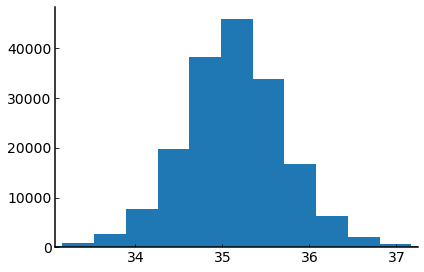

In [33]:
plt.hist(np.log10(df_QSO['[O_III] 5007 Luminosity']), bins=40)
plt.xlim(np.nanpercentile(np.log10(df_QSO['[O_III] 5007 Luminosity']), .3),
         np.nanpercentile(np.log10(df_QSO['[O_III] 5007 Luminosity']), 99.9))

In [34]:
def linear_fit(x, m, c):
    return m*x + c

In [35]:
from scipy.optimize import curve_fit

In [36]:
df_QSO.columns

Index(['Object', 'RA', 'Dec', 'z', 'H_alpha Flux', 'H_alpha EW', 'H_beta Flux',
       'H_beta EW', '[O_III] 5007 Flux', '[O_III] 5007 EW', 'C_III] 1908 Flux',
       'C_III] 1908 EW', 'He_II 4685 Flux', 'He_II 4685 EW',
       '[Ne_III] 3868 Flux', '[Ne_III] 3868 EW', '[N_II] 6583 Flux',
       '[N_II] 6583 EW', '[Ne_V] 3425 Flux', '[Ne_V] 3425 EW',
       '[Ne_V] 3425 SNR_L', '[Ne_V] 3425 SNR_C', '[Fe_VII] 5721 Flux',
       '[Fe_VII] 5721 EW', '[Fe_VII] 5721 SNR_L', '[Fe_VII] 5721 SNR_C',
       '[Fe_VII] 6087 Flux', '[Fe_VII] 6087 EW', '[Fe_VII] 6087 SNR_L',
       '[Fe_VII] 6087 SNR_C', 'D_L', '[O_III] 5007 Luminosity',
       '[Ne_V] 3425 Detection', '[Fe_VII] 5721 Detection',
       '[Fe_VII] 6087 Detection', '[Ne_V] 3425 Delta_Flux',
       '[Fe_VII] 5721 Delta_Flux', '[Fe_VII] 6087 Delta_Flux'],
      dtype='object')

In [37]:
idx = (df_QSO['[Ne_V] 3425 Detection']==2)

/Users/thepoetoftwilight/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'log10(OIII Luminosity (W))')

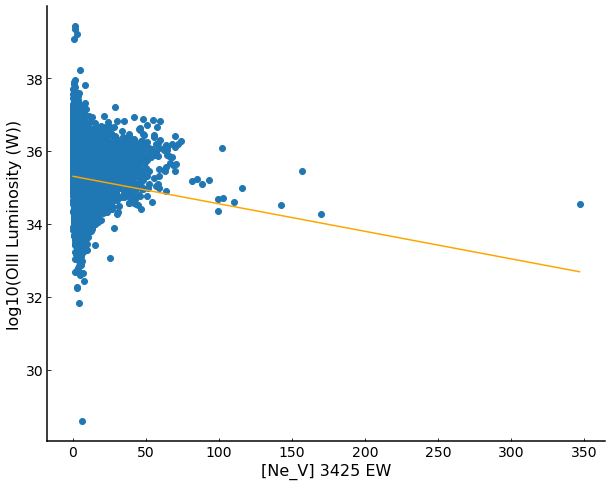

In [38]:
fig, ax = plt.subplots(1, figsize=(10, 8))

ax.scatter(df_QSO[idx]['[Ne_V] 3425 EW'], np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']))

valid_idx = ~(np.isnan(df_QSO[idx]['[Ne_V] 3425 EW']) | np.isnan(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity'])))

lin_opt, lin_covar = curve_fit(linear_fit, df_QSO[idx]['[Ne_V] 3425 EW'][valid_idx],
                               np.log10(df_QSO[idx]['[O_III] 5007 Luminosity'][valid_idx]))

x = np.arange(np.nanmin(df_QSO[idx]['[Ne_V] 3425 EW']), np.nanmax(df_QSO[idx]['[Ne_V] 3425 EW']), 1)

ax.plot(x, linear_fit(x, *lin_opt), color='orange')

ax.set_xlabel(r'[Ne_V] 3425 EW')
ax.set_ylabel('log10(OIII Luminosity (W))')
#ax.set_xlim(0, 100)

In [39]:
idx = (df_QSO['[Fe_VII] 5721 Detection']==2)

/Users/thepoetoftwilight/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'log10(OIII Luminosity (W))')

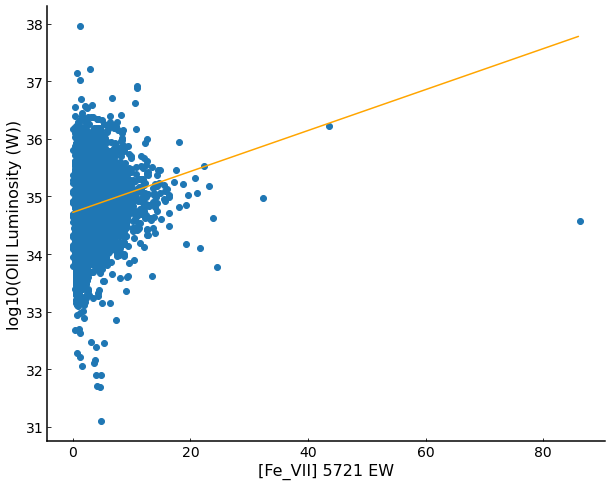

In [40]:
fig, ax = plt.subplots(1, figsize=(10, 8))

ax.scatter(df_QSO[idx]['[Fe_VII] 5721 EW'], np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']))

valid_idx = ~(np.isnan(df_QSO[idx]['[Fe_VII] 5721 EW']) | np.isnan(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity'])))


lin_opt, lin_covar = curve_fit(linear_fit, df_QSO[idx]['[Fe_VII] 5721 EW'][valid_idx],
                               np.log10(df_QSO[idx]['[O_III] 5007 Luminosity'][valid_idx]))

x = np.arange(np.nanmin(df_QSO[idx]['[Fe_VII] 5721 EW']), np.nanmax(df_QSO[idx]['[Fe_VII] 5721 EW']), 1)

ax.plot(x, linear_fit(x, *lin_opt), color='orange')

ax.set_xlabel(r'[Fe_VII] 5721 EW')
ax.set_ylabel('log10(OIII Luminosity (W))')
#ax.set_xlim(0, 100)

In [41]:
idx = (df_QSO['[Fe_VII] 6087 Detection']==2)

/Users/thepoetoftwilight/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'log10(OIII Luminosity (W))')

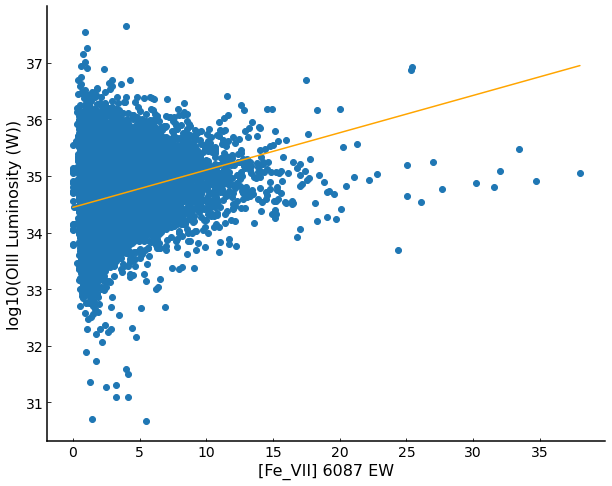

In [42]:
fig, ax = plt.subplots(1, figsize=(10, 8))

ax.scatter(df_QSO[idx]['[Fe_VII] 6087 EW'], np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']))

valid_idx = ~(np.isnan(df_QSO[idx]['[Fe_VII] 6087 EW']) | np.isnan(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity'])))


lin_opt, lin_covar = curve_fit(linear_fit, df_QSO[idx]['[Fe_VII] 6087 EW'][valid_idx],
                               np.log10(df_QSO[idx]['[O_III] 5007 Luminosity'][valid_idx]))

x = np.arange(np.nanmin(df_QSO[idx]['[Fe_VII] 6087 EW']), np.nanmax(df_QSO[idx]['[Fe_VII] 6087 EW']), 1)

ax.plot(x, linear_fit(x, *lin_opt), color='orange')

ax.set_xlabel(r'[Fe_VII] 6087 EW')
ax.set_ylabel('log10(OIII Luminosity (W))')
#ax.set_xlim(0, 100)

In [43]:
colors = ['red', 'green', 'blue', 'orange', 
          'brown', 'purple', 'magenta', 'slategrey', 'black']

In [44]:
from scipy.stats import percentileofscore

In [45]:
df_CLIF[['[Fe_VII] 6087 EW', '[Ne_V] 3425 EW']]

,[Fe_VII] 6087 EW,[Ne_V] 3425 EW
0,16.511050,84.914522
1,14.221384,48.026295
2,6.203368,NaN
3,7.822419,NaN
4,11.397415,NaN
5,26.110000,66.400000
6,2.190000,18.630000
7,11.050000,60.830000
8,2.600000,14.300000


In [47]:
for i in range(len(df_CLIF)):
    
    name = df_CLIF.loc[i]['Common Name']
    
    x1 = df_CLIF.loc[i]['[Fe_VII] 6087 EW']
    x2 = df_CLIF.loc[i]['[Ne_V] 3425 EW']
    
    p1 = percentileofscore(df_QSO['[Fe_VII] 6087 EW'].dropna(), x1)
    p2 = percentileofscore(df_QSO['[Ne_V] 3425 EW'].dropna(), x2)
    
    print(name + ', ' + str(np.round(p1, 2)) + ', ' + str(np.round(p2, 2)))

J1031+26, 99.89, 100.0
J1641+43, 99.8, 99.97
J1241+44, 96.54, nan
III Zw 77, 98.24, nan
Mrk 1388, 99.52, nan
Q1131+16, 99.98, 99.99
ESO 138 G1, 43.69, 99.57
Tololo 0109-383, 99.45, 99.99
J0717+37, 53.53, 99.26


In [48]:
idx = (df_QSO['[Ne_V] 3425 Detection']==2)&(df_QSO['[Fe_VII] 6087 Detection']==2)

In [50]:
np.nanmedian(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']))

/Users/thepoetoftwilight/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


34.85508877144888

/Users/thepoetoftwilight/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


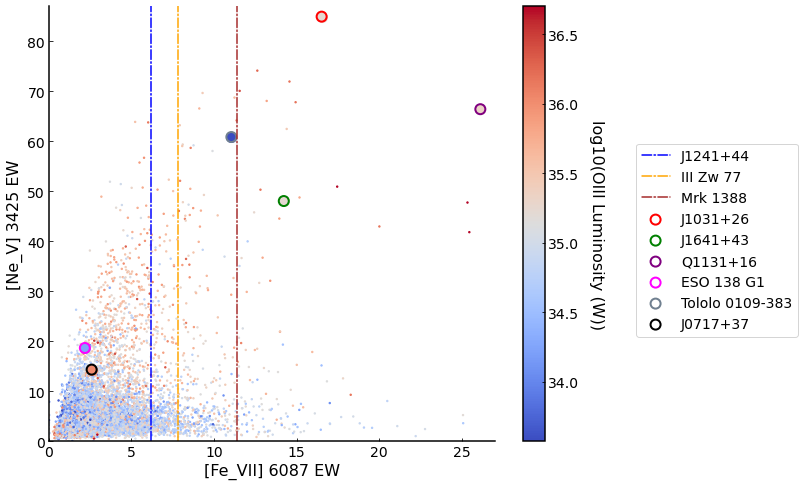

In [55]:
fig, ax = plt.subplots(1, figsize=(10, 8))

im = ax.scatter(df_QSO[idx]['[Fe_VII] 6087 EW'], 
                df_QSO[idx]['[Ne_V] 3425 EW'], 
                s=2, c=np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 
                cmap='coolwarm',
                vmin = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 0.3),
                vmax = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 99.9),
                alpha=1)

cbar = plt.colorbar(im, ax=ax)

cbar.set_label('log10(OIII Luminosity (W))', labelpad=25, rotation=270)

for i in range(len(df_CLIF)):
    
    obj_name = df_CLIF.loc[i]['Common Name']
    
    x = df_CLIF.loc[i]['[Fe_VII] 6087 EW']
    y = df_CLIF.loc[i]['[Ne_V] 3425 EW']
    heat = df_CLIF.loc[i]['[O_III] 5007 Luminosity']
    
    if(np.isnan(x)==True and np.isnan(y)==False):
        ax.axhline(y, c=colors[i], label=obj_name, linestyle=':')
        
    elif(np.isnan(x)==False and np.isnan(y)==True):
        ax.axvline(x, c=colors[i], label=obj_name, linestyle='-.')
        
    else:
        ax.scatter(x, y,
                   c=np.log10(heat), cmap='coolwarm',
                   vmin = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 0.3),
                   vmax = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 99.9), s=100)
        ax.scatter(x, y, label=obj_name, s=100, facecolors='None', 
                           edgecolors=colors[i], linewidth=2)

ax.set_xlim(0, 27)
            #np.nanpercentile(df_QSO[idx]['[Fe_VII] 6087 EW'],99))
ax.set_ylim(0, 87)
            #np.nanpercentile(df_QSO[idx]['[Ne_V] 3425 EW'],98))
ax.set_xlabel(r'[Fe_VII] 6087 EW')
ax.set_ylabel(r'[Ne_V] 3425 EW')
ax.legend(bbox_to_anchor=(1.3,.7), loc="upper left")

plt.savefig('Figures/diagnostic1.pdf', dpi=300, bbox_inches='tight')

/Users/thepoetoftwilight/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


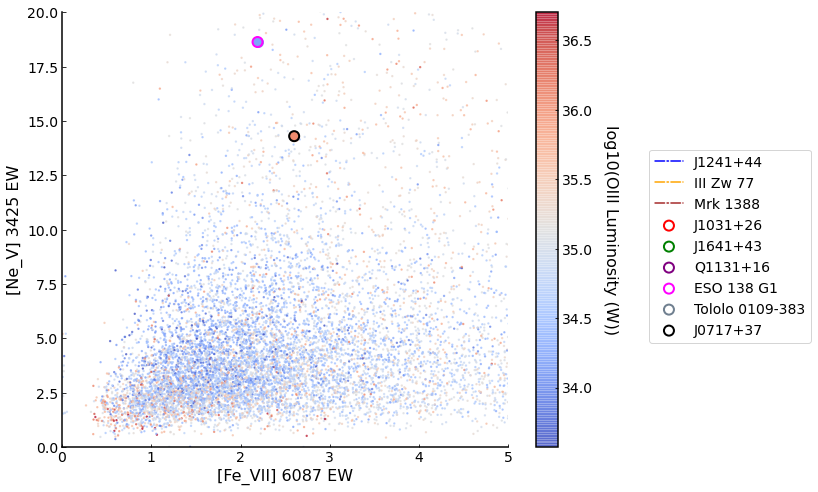

In [49]:
fig, ax = plt.subplots(1, figsize=(10, 8))

im = ax.scatter(df_QSO[idx]['[Fe_VII] 6087 EW'], 
                df_QSO[idx]['[Ne_V] 3425 EW'], 
                s=2, c=np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 
                cmap='coolwarm',
                vmin = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 0.3),
                vmax = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 99.9),
                alpha=.6)

cbar = plt.colorbar(im, ax=ax)

cbar.set_label('log10(OIII Luminosity (W))', labelpad=25, rotation=270)

for i in range(len(df_CLIF)):
    
    obj_name = df_CLIF.loc[i]['Common Name']
    
    x = df_CLIF.loc[i]['[Fe_VII] 6087 EW']
    y = df_CLIF.loc[i]['[Ne_V] 3425 EW']
    heat = df_CLIF.loc[i]['[O_III] 5007 Luminosity']
    
    if(np.isnan(x)==True and np.isnan(y)==False):
        ax.axhline(y, c=colors[i], label=obj_name, linestyle=':')
        
    elif(np.isnan(x)==False and np.isnan(y)==True):
        ax.axvline(x, c=colors[i], label=obj_name, linestyle='-.')
        
    else:
        ax.scatter(x, y,
                   c=np.log10(heat), cmap='coolwarm',
                   vmin = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 0.3),
                   vmax = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 99.9), s=100)
        ax.scatter(x, y, label=obj_name, s=100, facecolors='None', 
                           edgecolors=colors[i], linewidth=2)

ax.set_xlim(0, 5)
            #np.nanpercentile(df_QSO[idx]['[Fe_VII] 6087 EW'],99))
ax.set_ylim(0, 20)
            #np.nanpercentile(df_QSO[idx]['[Ne_V] 3425 EW'],98))
ax.set_xlabel(r'[Fe_VII] 6087 EW')
ax.set_ylabel(r'[Ne_V] 3425 EW')
ax.legend(bbox_to_anchor=(1.3,.7), loc="upper left")

plt.savefig('Figures/diagnostic1_zoom.pdf', dpi=300, bbox_inches='tight')

In [50]:
df_CLIF['[Fe_VII] 6087 Flux']/df_CLIF['[O_III] 5007 Flux']

0    0.095992
1    0.065351
2    0.299851
3    0.047382
4    0.420734
5    0.094076
6    0.026645
7    0.744097
8    0.050841
dtype: float64

In [51]:
df_CLIF['[Ne_V] 3425 Flux']/df_CLIF['H_beta Flux']

0    2.789820
1    1.365870
2         NaN
3         NaN
4         NaN
5    1.050633
6    1.796117
7    0.566770
8    1.925481
dtype: float64

In [52]:
for i in range(len(df_CLIF)):
    
    name = df_CLIF.loc[i]['Common Name']
    
    x1 = df_CLIF.loc[i]['[Fe_VII] 6087 Flux']/df_CLIF.loc[i]['[O_III] 5007 Flux']
    x2 = df_CLIF.loc[i]['[Ne_V] 3425 Flux']/df_CLIF.loc[i]['H_beta Flux']
    
    p1 = percentileofscore((df_QSO['[Fe_VII] 6087 Flux']/df_QSO['[O_III] 5007 Flux']).dropna(), x1)
    p2 = percentileofscore((df_QSO['[Ne_V] 3425 Flux']/df_QSO['H_beta Flux']).dropna(), x2)
    
    print(name + ', ' + str(np.round(p1, 2)) + ', ' + str(np.round(p2, 2)))

J1031+26, 63.24, 99.75
J1641+43, 45.77, 99.39
J1241+44, 95.71, nan
III Zw 77, 32.64, nan
Mrk 1388, 97.89, nan
Q1131+16, 62.28, 99.12
ESO 138 G1, 16.41, 99.58
Tololo 0109-383, 99.28, 97.86
J0717+37, 35.23, 99.62


In [53]:
idx = (df_QSO['[Ne_V] 3425 Detection']==2)&(df_QSO['[Fe_VII] 6087 Detection']==2)

/Users/thepoetoftwilight/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


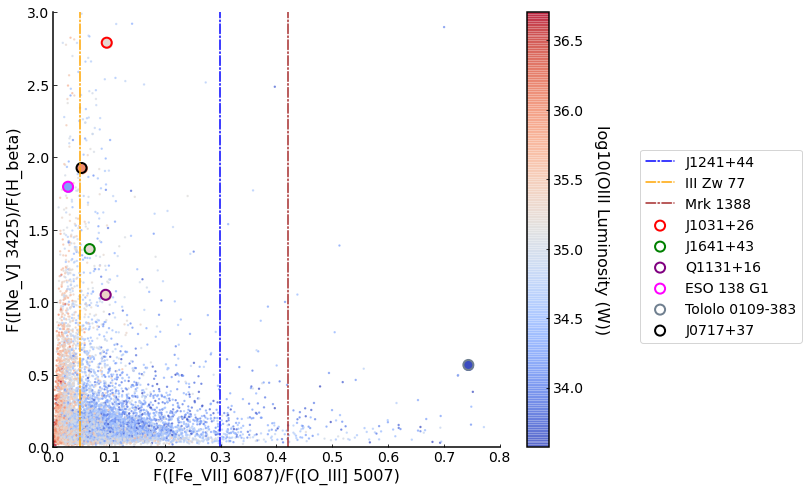

In [54]:
fig, ax = plt.subplots(1, figsize=(10, 8))

im = ax.scatter(df_QSO[idx]['[Fe_VII] 6087 Flux']/df_QSO[idx]['[O_III] 5007 Flux'], 
                df_QSO[idx]['[Ne_V] 3425 Flux']/df_QSO[idx]['H_beta Flux'], 
                s=2, c=np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 
                cmap='coolwarm',
                vmin = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 0.3),
                vmax = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 99.9),
                alpha=.6)

cbar = plt.colorbar(im, ax=ax)

cbar.set_label('log10(OIII Luminosity (W))', labelpad=25, rotation=270)

for i in range(len(df_CLIF)):
    
    obj_name = df_CLIF.loc[i]['Common Name']
    
    x = df_CLIF.loc[i]['[Fe_VII] 6087 Flux']/df_CLIF.loc[i]['[O_III] 5007 Flux']
    y = df_CLIF.loc[i]['[Ne_V] 3425 Flux']/df_CLIF.loc[i]['H_beta Flux']
    heat = df_CLIF.loc[i]['[O_III] 5007 Luminosity']
    
    if(np.isnan(x)==True and np.isnan(y)==False):
        ax.axhline(y, c=colors[i], label=obj_name, linestyle=':')
        
    elif(np.isnan(x)==False and np.isnan(y)==True):
        ax.axvline(x, c=colors[i], label=obj_name, linestyle='-.')
        
    else:
        ax.scatter(x, y,
                   c=np.log10(heat), cmap='coolwarm',
                   vmin = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 0.3),
                   vmax = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 99.9), s=100)
        ax.scatter(x, y, label=obj_name, s=100, facecolors='None', 
                           edgecolors=colors[i], linewidth=2)

ax.set_xlim(0, .8)
ax.set_ylim(0, 3)
ax.set_xlabel(r'F([Fe_VII] 6087)/F([O_III] 5007)')
ax.set_ylabel(r'F([Ne_V] 3425)/F(H_beta)')
ax.legend(bbox_to_anchor=(1.3,.7), loc="upper left")

plt.savefig('Figures/diagnostic2.pdf', dpi=300, bbox_inches='tight')

In [55]:
df_CLIF['[Fe_VII] 6087 Flux']/df_CLIF['H_beta Flux']

0    0.900089
1    0.347011
2    1.301354
3    0.275762
4    3.605688
5    0.495781
6    0.239806
7    0.277950
8    0.682692
dtype: float64

In [56]:
df_CLIF['[Ne_V] 3425 Flux']/df_CLIF['H_beta Flux']

0    2.789820
1    1.365870
2         NaN
3         NaN
4         NaN
5    1.050633
6    1.796117
7    0.566770
8    1.925481
dtype: float64

/Users/thepoetoftwilight/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


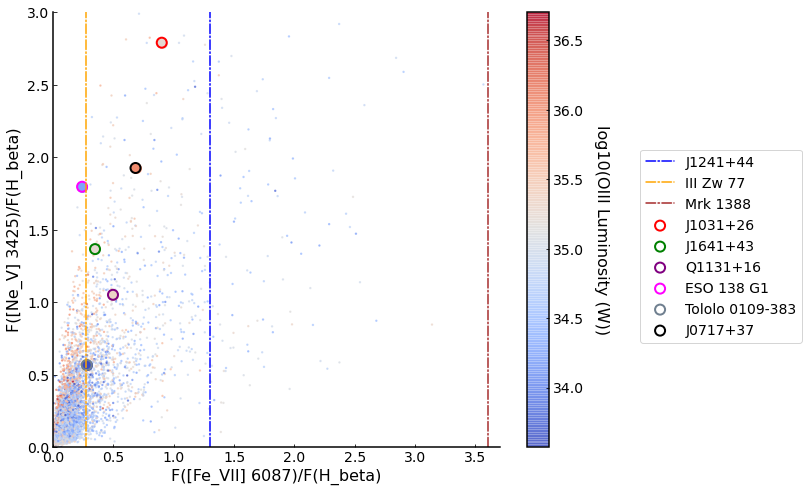

In [57]:
fig, ax = plt.subplots(1, figsize=(10, 8))

im = ax.scatter(df_QSO[idx]['[Fe_VII] 6087 Flux']/df_QSO[idx]['H_beta Flux'], 
                df_QSO[idx]['[Ne_V] 3425 Flux']/df_QSO[idx]['H_beta Flux'], 
                s=2, c=np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 
                cmap='coolwarm',
                vmin = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 0.3),
                vmax = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 99.9),
                alpha=.6)

cbar = plt.colorbar(im, ax=ax)

cbar.set_label('log10(OIII Luminosity (W))', labelpad=25, rotation=270)

for i in range(len(df_CLIF)):
    
    obj_name = df_CLIF.loc[i]['Common Name']
    
    x = df_CLIF.loc[i]['[Fe_VII] 6087 Flux']/df_CLIF.loc[i]['H_beta Flux']
    y = df_CLIF.loc[i]['[Ne_V] 3425 Flux']/df_CLIF.loc[i]['H_beta Flux']
    heat = df_CLIF.loc[i]['[O_III] 5007 Luminosity']
    
    if(np.isnan(x)==True and np.isnan(y)==False):
        ax.axhline(y, c=colors[i], label=obj_name, linestyle=':')
        
    elif(np.isnan(x)==False and np.isnan(y)==True):
        ax.axvline(x, c=colors[i], label=obj_name, linestyle='-.')
        
    else:
        ax.scatter(x, y,
                   c=np.log10(heat), cmap='coolwarm',
                   vmin = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 0.3),
                   vmax = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 99.9), s=100)
        ax.scatter(x, y, label=obj_name, s=100, facecolors='None', 
                           edgecolors=colors[i], linewidth=2)

ax.set_xlim(0, 3.7)
ax.set_ylim(0, 3)
ax.set_xlabel(r'F([Fe_VII] 6087)/F(H_beta)')
ax.set_ylabel(r'F([Ne_V] 3425)/F(H_beta)')
ax.legend(bbox_to_anchor=(1.3,.7), loc="upper left")

plt.savefig('Figures/diagnostic3.pdf', dpi=300, bbox_inches='tight')

/Users/thepoetoftwilight/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


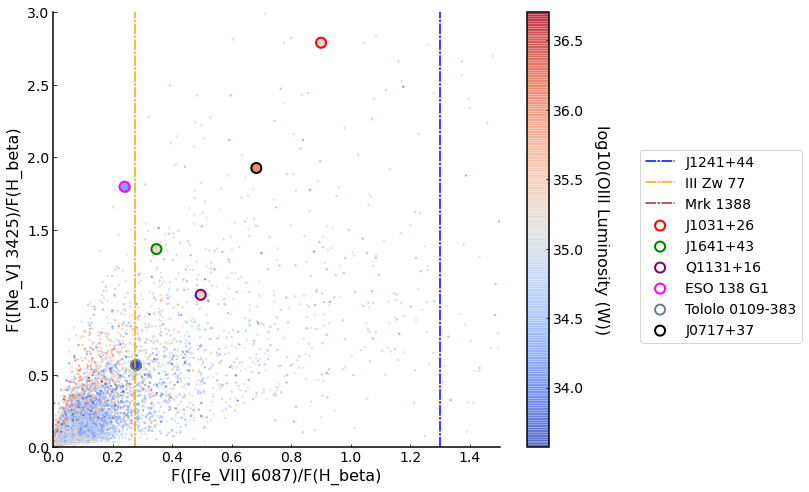

In [58]:
fig, ax = plt.subplots(1, figsize=(10, 8))

im = ax.scatter(df_QSO[idx]['[Fe_VII] 6087 Flux']/df_QSO[idx]['H_beta Flux'], 
                df_QSO[idx]['[Ne_V] 3425 Flux']/df_QSO[idx]['H_beta Flux'], 
                s=2, c=np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 
                cmap='coolwarm',
                vmin = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 0.3),
                vmax = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 99.9),
                alpha=.6)

cbar = plt.colorbar(im, ax=ax)

cbar.set_label('log10(OIII Luminosity (W))', labelpad=25, rotation=270)

for i in range(len(df_CLIF)):
    
    obj_name = df_CLIF.loc[i]['Common Name']
    
    x = df_CLIF.loc[i]['[Fe_VII] 6087 Flux']/df_CLIF.loc[i]['H_beta Flux']
    y = df_CLIF.loc[i]['[Ne_V] 3425 Flux']/df_CLIF.loc[i]['H_beta Flux']
    heat = df_CLIF.loc[i]['[O_III] 5007 Luminosity']
    
    if(np.isnan(x)==True and np.isnan(y)==False):
        ax.axhline(y, c=colors[i], label=obj_name, linestyle=':')
        
    elif(np.isnan(x)==False and np.isnan(y)==True):
        ax.axvline(x, c=colors[i], label=obj_name, linestyle='-.')
        
    else:
        ax.scatter(x, y,
                   c=np.log10(heat), cmap='coolwarm',
                   vmin = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 0.3),
                   vmax = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 99.9), s=100)
        ax.scatter(x, y, label=obj_name, s=100, facecolors='None', 
                           edgecolors=colors[i], linewidth=2)

ax.set_xlim(0, 1.5)
ax.set_ylim(0, 3)
ax.set_xlabel(r'F([Fe_VII] 6087)/F(H_beta)')
ax.set_ylabel(r'F([Ne_V] 3425)/F(H_beta)')
ax.legend(bbox_to_anchor=(1.3,.7), loc="upper left")

plt.savefig('Figures/diagnostic3_zoom.pdf', dpi=300, bbox_inches='tight')

In [59]:
df_CLIF['[Fe_VII] 6087 Flux']/df_CLIF['H_alpha Flux']

0    0.111770
1    0.064500
2    0.204615
3    0.066449
4    0.912832
5    0.099216
6    0.056425
7    0.063466
8         NaN
dtype: float64

In [60]:
df_CLIF['[Ne_V] 3425 Flux']/df_CLIF['H_beta Flux']

0    2.789820
1    1.365870
2         NaN
3         NaN
4         NaN
5    1.050633
6    1.796117
7    0.566770
8    1.925481
dtype: float64

In [61]:
for i in range(len(df_CLIF)):
    
    name = df_CLIF.loc[i]['Common Name']
    
    x1 = df_CLIF.loc[i]['[Fe_VII] 6087 Flux']/df_CLIF.loc[i]['H_alpha Flux']
    x2 = df_CLIF.loc[i]['[Ne_V] 3425 Flux']/df_CLIF.loc[i]['H_beta Flux']
    
    p1 = percentileofscore((df_QSO['[Fe_VII] 6087 Flux']/df_QSO['H_alpha Flux']).dropna(), x1)
    p2 = percentileofscore((df_QSO['[Ne_V] 3425 Flux']/df_QSO['H_beta Flux']).dropna(), x2)
    
    print(name + ', ' + str(np.round(p1, 2)) + ', ' + str(np.round(p2, 2)) + ', ' + str(round(x1, 2)) + ', ' + str(round(x2, 2)))

J1031+26, 95.96, 99.75, 0.11, 2.79
J1641+43, 90.5, 99.39, 0.06, 1.37
J1241+44, 98.94, nan, 0.2, nan
III Zw 77, 90.82, nan, 0.07, nan
Mrk 1388, 99.96, nan, 0.91, nan
Q1131+16, 94.98, 99.12, 0.1, 1.05
ESO 138 G1, 88.8, 99.58, 0.06, 1.8
Tololo 0109-383, 90.31, 97.86, 0.06, 0.57
J0717+37, nan, 99.62, nan, 1.93


/Users/thepoetoftwilight/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


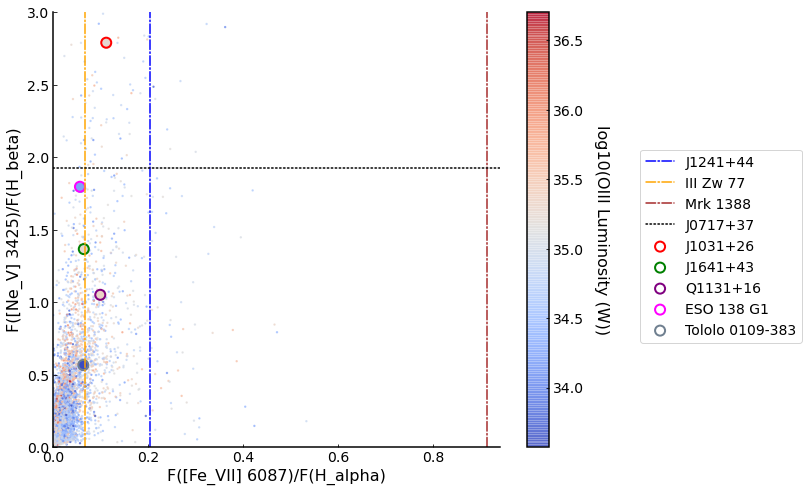

In [62]:
fig, ax = plt.subplots(1, figsize=(10, 8))

im = ax.scatter(df_QSO[idx]['[Fe_VII] 6087 Flux']/df_QSO[idx]['H_alpha Flux'], 
                df_QSO[idx]['[Ne_V] 3425 Flux']/df_QSO[idx]['H_beta Flux'], 
                s=2, c=np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 
                cmap='coolwarm',
                vmin = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 0.3),
                vmax = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 99.9),
                alpha=.6)

cbar = plt.colorbar(im, ax=ax)

cbar.set_label('log10(OIII Luminosity (W))', labelpad=25, rotation=270)

for i in range(len(df_CLIF)):
    
    obj_name = df_CLIF.loc[i]['Common Name']
    
    x = df_CLIF.loc[i]['[Fe_VII] 6087 Flux']/df_CLIF.loc[i]['H_alpha Flux']
    y = df_CLIF.loc[i]['[Ne_V] 3425 Flux']/df_CLIF.loc[i]['H_beta Flux']
    heat = df_CLIF.loc[i]['[O_III] 5007 Luminosity']
    
    if(np.isnan(x)==True and np.isnan(y)==False):
        ax.axhline(y, c=colors[i], label=obj_name, linestyle=':')
        
    elif(np.isnan(x)==False and np.isnan(y)==True):
        ax.axvline(x, c=colors[i], label=obj_name, linestyle='-.')
        
    else:
        ax.scatter(x, y,
                   c=np.log10(heat), cmap='coolwarm',
                   vmin = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 0.3),
                   vmax = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 99.9), s=100)
        ax.scatter(x, y, label=obj_name, s=100, facecolors='None', 
                           edgecolors=colors[i], linewidth=2)

ax.set_xlim(0, .94)
ax.set_ylim(0, 3)
ax.set_xlabel(r'F([Fe_VII] 6087)/F(H_alpha)')
ax.set_ylabel(r'F([Ne_V] 3425)/F(H_beta)')
ax.legend(bbox_to_anchor=(1.3,.7), loc="upper left")

plt.savefig('Figures/diagnostic4.pdf', dpi=300, bbox_inches='tight')

/Users/thepoetoftwilight/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


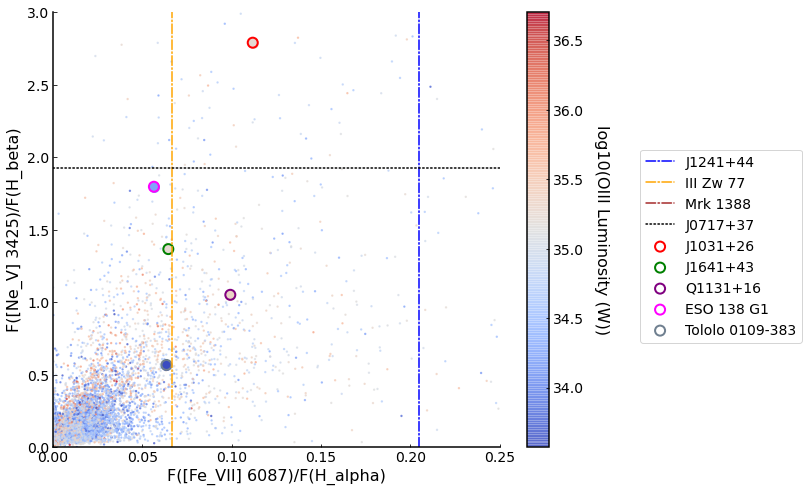

In [63]:
fig, ax = plt.subplots(1, figsize=(10, 8))

im = ax.scatter(df_QSO[idx]['[Fe_VII] 6087 Flux']/df_QSO[idx]['H_alpha Flux'], 
                df_QSO[idx]['[Ne_V] 3425 Flux']/df_QSO[idx]['H_beta Flux'], 
                s=2, c=np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 
                cmap='coolwarm',
                vmin = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 0.3),
                vmax = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 99.9),
                alpha=.6)

cbar = plt.colorbar(im, ax=ax)

cbar.set_label('log10(OIII Luminosity (W))', labelpad=25, rotation=270)

for i in range(len(df_CLIF)):
    
    obj_name = df_CLIF.loc[i]['Common Name']
    
    x = df_CLIF.loc[i]['[Fe_VII] 6087 Flux']/df_CLIF.loc[i]['H_alpha Flux']
    y = df_CLIF.loc[i]['[Ne_V] 3425 Flux']/df_CLIF.loc[i]['H_beta Flux']
    heat = df_CLIF.loc[i]['[O_III] 5007 Luminosity']
    
    if(np.isnan(x)==True and np.isnan(y)==False):
        ax.axhline(y, c=colors[i], label=obj_name, linestyle=':')
        
    elif(np.isnan(x)==False and np.isnan(y)==True):
        ax.axvline(x, c=colors[i], label=obj_name, linestyle='-.')
        
    else:
        ax.scatter(x, y,
                   c=np.log10(heat), cmap='coolwarm',
                   vmin = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 0.3),
                   vmax = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 99.9), s=100)
        ax.scatter(x, y, label=obj_name, s=100, facecolors='None', 
                           edgecolors=colors[i], linewidth=2)

ax.set_xlim(0, .25)
ax.set_ylim(0, 3)
ax.set_xlabel(r'F([Fe_VII] 6087)/F(H_alpha)')
ax.set_ylabel(r'F([Ne_V] 3425)/F(H_beta)')
ax.legend(bbox_to_anchor=(1.3,.7), loc="upper left")

plt.savefig('Figures/diagnostic4_zoom.pdf', dpi=300, bbox_inches='tight')

In [64]:
df_CLIF[['[Fe_VII] 6087 EW', '[Fe_VII] 5721 EW']]

,[Fe_VII] 6087 EW,[Fe_VII] 5721 EW
0,16.511050,9.569895
1,14.221384,7.697506
2,6.203368,2.580507
3,7.822419,3.741649
4,11.397415,5.870025
5,26.110000,20.130000
6,2.190000,1.010000
7,11.050000,5.700000
8,2.600000,2.000000


In [65]:
idx = (df_QSO['[Fe_VII] 6087 Detection']==2)&(df_QSO['[Fe_VII] 5721 Detection']==2)

/Users/thepoetoftwilight/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


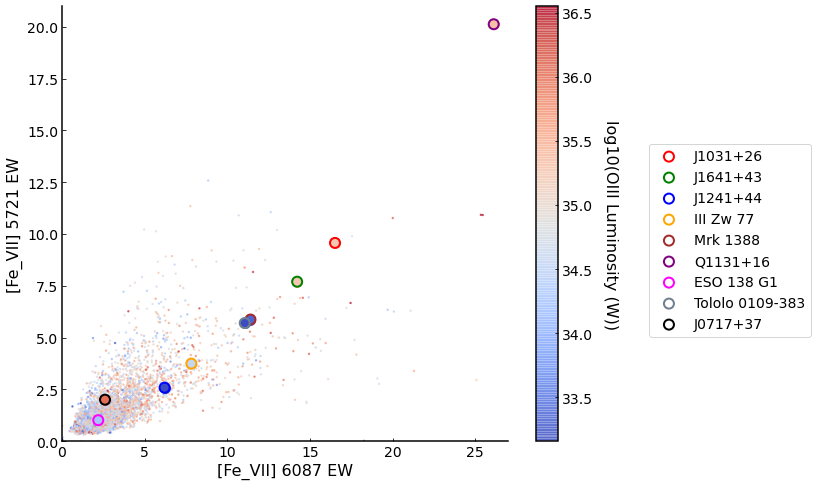

In [66]:
fig, ax = plt.subplots(1, figsize=(10, 8))

im = ax.scatter(df_QSO[idx]['[Fe_VII] 6087 EW'], 
                df_QSO[idx]['[Fe_VII] 5721 EW'], 
                s=2, c=np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 
                cmap='coolwarm',
                vmin = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 0.3),
                vmax = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 99.9),
                alpha=.6)

cbar = plt.colorbar(im, ax=ax)

cbar.set_label('log10(OIII Luminosity (W))', labelpad=25, rotation=270)

for i in range(len(df_CLIF)):
    
    obj_name = df_CLIF.loc[i]['Common Name']
    
    x = df_CLIF.loc[i]['[Fe_VII] 6087 EW']
    y = df_CLIF.loc[i]['[Fe_VII] 5721 EW']
    heat = df_CLIF.loc[i]['[O_III] 5007 Luminosity']
    
    if(np.isnan(x)==True and np.isnan(y)==False):
        ax.axhline(y, c=colors[i], label=obj_name, linestyle=':')
        
    elif(np.isnan(x)==False and np.isnan(y)==True):
        ax.axvline(x, c=colors[i], label=obj_name, linestyle='-.')
        
    else:
        ax.scatter(x, y,
                   c=np.log10(heat), cmap='coolwarm',
                   vmin = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 0.3),
                   vmax = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 99.9), s=100)
        ax.scatter(x, y, label=obj_name, s=100, facecolors='None', 
                           edgecolors=colors[i], linewidth=2)

ax.set_xlim(0, 27)
            #np.nanpercentile(df_QSO[idx]['[Fe_VII] 6087 EW'],99))
ax.set_ylim(0, 21)
            #np.nanpercentile(df_QSO[idx]['[Fe_VII] 5721 EW'],98))
ax.set_xlabel(r'[Fe_VII] 6087 EW')
ax.set_ylabel(r'[Fe_VII] 5721 EW')
ax.legend(bbox_to_anchor=(1.3,.7), loc="upper left")

plt.savefig('Figures/diagnostic5.pdf', dpi=300, bbox_inches='tight')

In [67]:
df_CLIF[['[Fe_VII] 6087 Flux', '[Fe_VII] 5721 Flux']]

,[Fe_VII] 6087 Flux,[Fe_VII] 5721 Flux
0,85.723447,51.312946
1,78.424589,46.324824
2,64.547157,26.651883
3,694.919646,349.445871
4,955.507378,504.175825
5,235.000000,151.000000
6,2470.000000,1257.000000
7,1790.000000,832.000000
8,2.840000,2.140000


In [68]:
idx = (df_QSO['[Fe_VII] 6087 Detection']==2)&(df_QSO['[Fe_VII] 5721 Detection']==2)

/Users/thepoetoftwilight/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


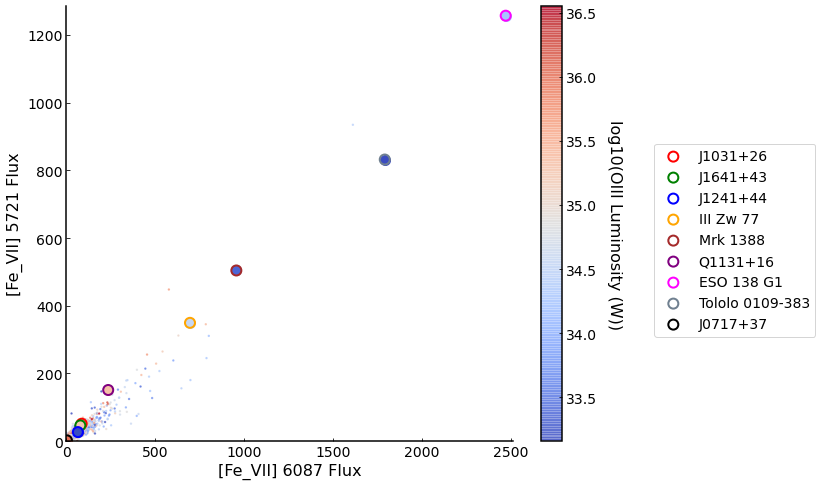

In [69]:
fig, ax = plt.subplots(1, figsize=(10, 8))

im = ax.scatter(df_QSO[idx]['[Fe_VII] 6087 Flux'], 
                df_QSO[idx]['[Fe_VII] 5721 Flux'], 
                s=2, c=np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 
                cmap='coolwarm',
                vmin = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 0.3),
                vmax = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 99.9),
                alpha=.6)

cbar = plt.colorbar(im, ax=ax)

cbar.set_label('log10(OIII Luminosity (W))', labelpad=25, rotation=270)

for i in range(len(df_CLIF)):
    
    obj_name = df_CLIF.loc[i]['Common Name']
    
    x = df_CLIF.loc[i]['[Fe_VII] 6087 Flux']
    y = df_CLIF.loc[i]['[Fe_VII] 5721 Flux']
    heat = df_CLIF.loc[i]['[O_III] 5007 Luminosity']
    
    if(np.isnan(x)==True and np.isnan(y)==False):
        ax.axhline(y, c=colors[i], label=obj_name, linestyle=':')
        
    elif(np.isnan(x)==False and np.isnan(y)==True):
        ax.axvline(x, c=colors[i], label=obj_name, linestyle='-.')
        
    else:
        ax.scatter(x, y,
                   c=np.log10(heat), cmap='coolwarm',
                   vmin = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 0.3),
                   vmax = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 99.9), s=100)
        ax.scatter(x, y, label=obj_name, s=100, facecolors='None', 
                           edgecolors=colors[i], linewidth=2)

ax.set_xlim(0, 2510)
            #np.nanpercentile(df_QSO[idx]['[Fe_VII] 6087 Flux'],99))
ax.set_ylim(0, 1285)
            #np.nanpercentile(df_QSO[idx]['[Fe_VII] 5721 Flux'],98))
ax.set_xlabel(r'[Fe_VII] 6087 Flux')
ax.set_ylabel(r'[Fe_VII] 5721 Flux')
ax.legend(bbox_to_anchor=(1.3,.7), loc="upper left")

plt.savefig('Figures/diagnostic6.pdf', dpi=300, bbox_inches='tight')

/Users/thepoetoftwilight/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


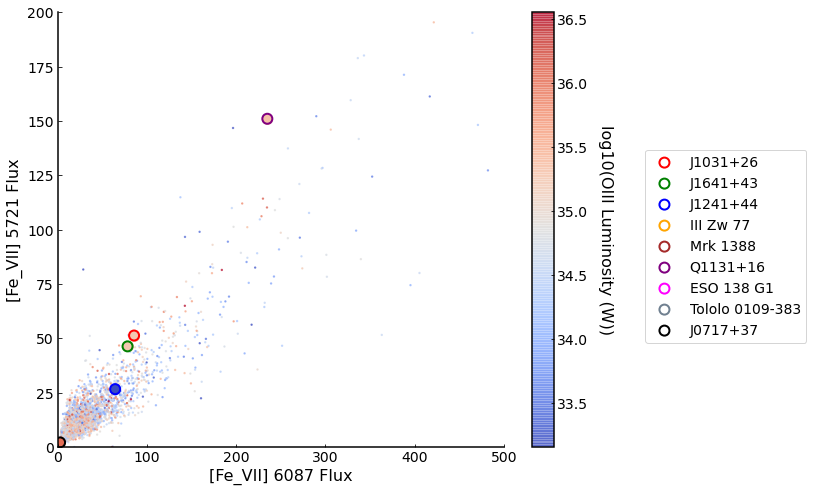

In [70]:
fig, ax = plt.subplots(1, figsize=(10, 8))

im = ax.scatter(df_QSO[idx]['[Fe_VII] 6087 Flux'], 
                df_QSO[idx]['[Fe_VII] 5721 Flux'], 
                s=2, c=np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 
                cmap='coolwarm',
                vmin = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 0.3),
                vmax = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 99.9),
                alpha=.6)

cbar = plt.colorbar(im, ax=ax)

cbar.set_label('log10(OIII Luminosity (W))', labelpad=25, rotation=270)

for i in range(len(df_CLIF)):
    
    obj_name = df_CLIF.loc[i]['Common Name']
    
    x = df_CLIF.loc[i]['[Fe_VII] 6087 Flux']
    y = df_CLIF.loc[i]['[Fe_VII] 5721 Flux']
    heat = df_CLIF.loc[i]['[O_III] 5007 Luminosity']
    
    if(np.isnan(x)==True and np.isnan(y)==False):
        ax.axhline(y, c=colors[i], label=obj_name, linestyle=':')
        
    elif(np.isnan(x)==False and np.isnan(y)==True):
        ax.axvline(x, c=colors[i], label=obj_name, linestyle='-.')
        
    else:
        ax.scatter(x, y,
                   c=np.log10(heat), cmap='coolwarm',
                   vmin = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 0.3),
                   vmax = np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 99.9), s=100)
        ax.scatter(x, y, label=obj_name, s=100, facecolors='None', 
                           edgecolors=colors[i], linewidth=2)

ax.set_xlim(0, 500)
            #np.nanpercentile(df_QSO[idx]['[Fe_VII] 6087 Flux'],99))
ax.set_ylim(0, 200)
            #np.nanpercentile(df_QSO[idx]['[Fe_VII] 5721 Flux'],98))
ax.set_xlabel(r'[Fe_VII] 6087 Flux')
ax.set_ylabel(r'[Fe_VII] 5721 Flux')
ax.legend(bbox_to_anchor=(1.3,.7), loc="upper left")

plt.savefig('Figures/diagnostic6_zoom.pdf', dpi=300, bbox_inches='tight')

In [71]:
np.log10(df_CLIF['[N_II] 6583 Flux']/df_CLIF['H_alpha Flux'])

0   -1.096446
1   -0.497786
2   -0.952199
3   -0.668658
4   -0.429280
5   -0.803287
6   -0.646118
7   -1.016381
8         NaN
dtype: float64

In [72]:
np.log10(df_CLIF['[O_III] 5007 Flux']/df_CLIF['H_beta Flux'])

0    0.972049
1    0.725095
2    0.637490
3    0.764923
4    0.932981
5    0.721811
6    0.954243
7   -0.427662
8    1.128008
dtype: float64

log([OIII]/Hβ) >
0.61/[log([NII]/Hα)−0.05]+1.3

 log([OIII]/Hβ) > 0.61/[log([NII]/Hα)−
0.47)] + 1.19

In [73]:
import matplotlib.patches as patches

/Users/thepoetoftwilight/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-74-b0b32df6b428>:14: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(x1, 0.61/(x1-0.47) + 1.19, linestyle = '-', color='gray')
<ipython-input-74-b0b32df6b428>:16: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(x2, 0.61/(x2-0.05) + 1.3, linestyle = ':', color='gray')
/Users/thepoetoftwilight/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


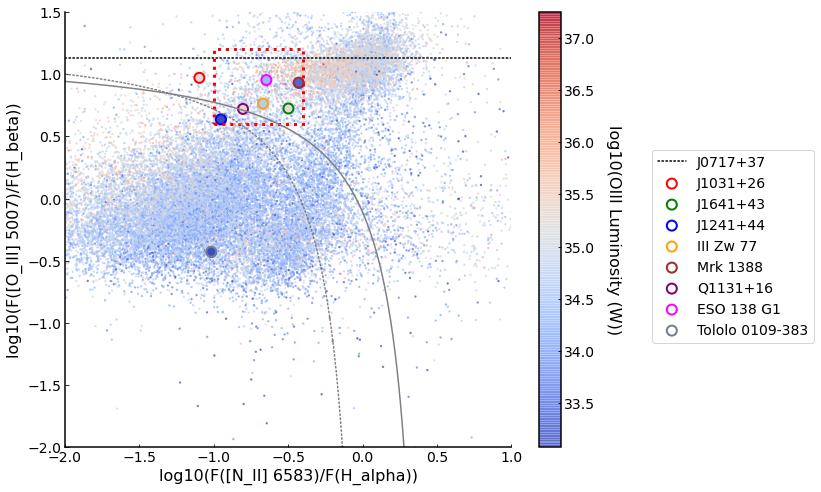

In [74]:
fig, ax = plt.subplots(1, figsize=(10, 8))

im = ax.scatter(np.log10(df_QSO['[N_II] 6583 Flux']/df_QSO['H_alpha Flux']), 
                np.log10(df_QSO['[O_III] 5007 Flux']/df_QSO['H_beta Flux']), 
                s=2, c=np.log10(df_QSO['[O_III] 5007 Luminosity']), 
                cmap='coolwarm',
                vmin = np.nanpercentile(np.log10(df_QSO['[O_III] 5007 Luminosity']), 0.3),
                vmax = np.nanpercentile(np.log10(df_QSO['[O_III] 5007 Luminosity']), 99.9),
                alpha=.6)

x1 = np.linspace(np.nanmin(np.log10(df_QSO['[N_II] 6583 Flux']/df_QSO['H_alpha Flux'])), 0.47, int(1e+5))
x2 = np.linspace(np.nanmin(np.log10(df_QSO['[N_II] 6583 Flux']/df_QSO['H_alpha Flux'])), 0.05, int(1e+5))

ax.plot(x1, 0.61/(x1-0.47) + 1.19, linestyle = '-', color='gray')

ax.plot(x2, 0.61/(x2-0.05) + 1.3, linestyle = ':', color='gray')

cbar = plt.colorbar(im, ax=ax)

cbar.set_label('log10(OIII Luminosity (W))', labelpad=25, rotation=270)

for i in range(len(df_CLIF)):
    
    obj_name = df_CLIF.loc[i]['Common Name']
    
    x = np.log10(df_CLIF.loc[i]['[N_II] 6583 Flux']/df_CLIF.loc[i]['H_alpha Flux'])
    y = np.log10(df_CLIF.loc[i]['[O_III] 5007 Flux']/df_CLIF.loc[i]['H_beta Flux'])
    heat = df_CLIF.loc[i]['[O_III] 5007 Luminosity']
    
    if(np.isnan(x)==True and np.isnan(y)==False):
        ax.axhline(y, c=colors[i], label=obj_name, linestyle=':')
        
    elif(np.isnan(x)==False and np.isnan(y)==True):
        ax.axvline(x, c=colors[i], label=obj_name, linestyle='-.')
        
    else:
        ax.scatter(x, y,
                   c=np.log10(heat), cmap='coolwarm',
                   vmin = np.nanpercentile(np.log10(df_QSO['[O_III] 5007 Luminosity']), 0.3),
                   vmax = np.nanpercentile(np.log10(df_QSO['[O_III] 5007 Luminosity']), 99.9), s=100)
        ax.scatter(x, y, label=obj_name, s=100, facecolors='None', 
                           edgecolors=colors[i], linewidth=2)

rect = patches.Rectangle((-1, .6), .6, .6, linewidth=3, edgecolor='r', facecolor='none', linestyle=':')

ax.add_patch(rect)
        
ax.set_xlim(-2, 1)
ax.set_ylim(-2, 1.5)
ax.set_xlabel(r'log10(F([N_II] 6583)/F(H_alpha))')
ax.set_ylabel(r'log10(F([O_III] 5007)/F(H_beta))')
ax.legend(bbox_to_anchor=(1.3,.7), loc="upper left")

plt.savefig('Figures/diagnostic7.pdf', dpi=300, bbox_inches='tight')

In [75]:
df_QSO.columns

Index(['Object', 'RA', 'Dec', 'z', 'H_alpha Flux', 'H_alpha EW', 'H_beta Flux',
       'H_beta EW', '[O_III] 5007 Flux', '[O_III] 5007 EW', 'C_III] 1908 Flux',
       'C_III] 1908 EW', 'He_II 4685 Flux', 'He_II 4685 EW',
       '[Ne_III] 3868 Flux', '[Ne_III] 3868 EW', '[N_II] 6583 Flux',
       '[N_II] 6583 EW', '[Ne_V] 3425 Flux', '[Ne_V] 3425 EW',
       '[Ne_V] 3425 SNR_L', '[Ne_V] 3425 SNR_C', '[Fe_VII] 5721 Flux',
       '[Fe_VII] 5721 EW', '[Fe_VII] 5721 SNR_L', '[Fe_VII] 5721 SNR_C',
       '[Fe_VII] 6087 Flux', '[Fe_VII] 6087 EW', '[Fe_VII] 6087 SNR_L',
       '[Fe_VII] 6087 SNR_C', 'D_L', '[O_III] 5007 Luminosity',
       '[Ne_V] 3425 Detection', '[Fe_VII] 5721 Detection',
       '[Fe_VII] 6087 Detection', '[Ne_V] 3425 Delta_Flux',
       '[Fe_VII] 5721 Delta_Flux', '[Fe_VII] 6087 Delta_Flux'],
      dtype='object')

In [76]:
np.nanmax(df_QSO['[O_III] 5007 Luminosity'])

8.164578503144765e+41

(array([1.85156e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([-7.13870745e+39,  7.52209483e+40,  1.57580604e+41,  2.39940260e+41,
         3.22299916e+41,  4.04659571e+41,  4.87019227e+41,  5.69378883e+41,
         6.51738539e+41,  7.34098195e+41,  8.16457850e+41]),
 <BarContainer object of 10 artists>)

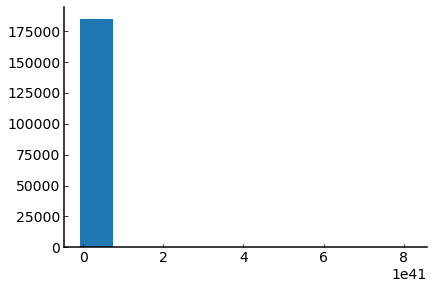

In [77]:
plt.hist(df_QSO['[O_III] 5007 Luminosity'])

In [71]:
idx = (df_QSO['[Ne_V] 3425 Detection']==2)&(df_QSO['[Fe_VII] 6087 Detection']==2)

In [72]:
bins = np.logspace(np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 0.0),
                   np.nanpercentile(np.log10(df_QSO[idx]['[O_III] 5007 Luminosity']), 99.9), 20)

/Users/thepoetoftwilight/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [73]:
bins

array([1.01745382e+33, 1.59208439e+33, 2.49125084e+33, 3.89824234e+33,
       6.09986479e+33, 9.54490442e+33, 1.49356098e+34, 2.33708406e+34,
       3.65700630e+34, 5.72238513e+34, 8.95423439e+34, 1.40113452e+35,
       2.19245763e+35, 3.43069874e+35, 5.36826515e+35, 8.40011697e+35,
       1.31442772e+36, 2.05678115e+36, 3.21839584e+36, 5.03605928e+36])

In [74]:
group = df_QSO[idx].groupby(pd.cut(df_QSO[idx]['[O_III] 5007 Luminosity'], bins))

In [75]:
plot_centers = (bins [:-1] + bins [1:])/2

plot_values_ne = group['[Ne_V] 3425 EW'].median()
plot_values_ne_lo = group['[Ne_V] 3425 EW'].quantile(.25)
plot_values_ne_hi = group['[Ne_V] 3425 EW'].quantile(.75)


std_ne = group['[Ne_V] 3425 EW'].std()
plot_values_fe = group['[Fe_VII] 6087 EW'].median()
plot_values_fe_lo = group['[Fe_VII] 6087 EW'].quantile(.25)
plot_values_fe_hi = group['[Fe_VII] 6087 EW'].quantile(.75)

std_fe = group['[Fe_VII] 6087 EW'].std()

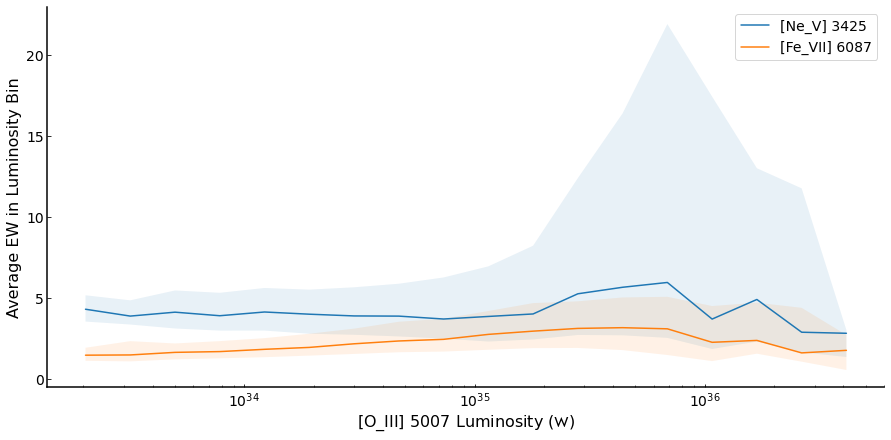

In [77]:
fig, ax = plt.subplots(1, figsize = (15, 7))
ax.set_xscale('log')
ax.plot(plot_centers, plot_values_ne, label='[Ne_V] 3425')
ax.fill_between(plot_centers, plot_values_ne_lo, plot_values_ne_hi, alpha=.1)
ax.plot(plot_centers, plot_values_fe, label='[Fe_VII] 6087')
ax.fill_between(plot_centers, plot_values_fe_lo, plot_values_fe_hi, alpha=.1)
ax.set_xlabel('[O_III] 5007 Luminosity ($W$)')
ax.set_ylabel('Average EW in Luminosity Bin')
ax.legend()

plt.savefig('Figures/diagnostic8.pdf', dpi=300, bbox_inches='tight')

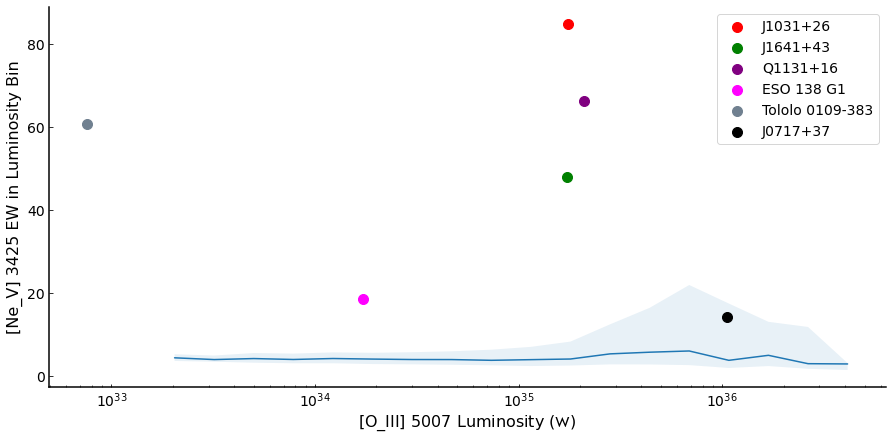

In [121]:
fig, ax = plt.subplots(1, figsize = (15, 7))
ax.set_xscale('log')
ax.plot(plot_centers, plot_values_ne)
ax.fill_between(plot_centers, plot_values_ne_lo, plot_values_ne_hi, alpha=.1)

for i in range(len(df_CLIF)):
    
    obj_name = df_CLIF.loc[i]['Common Name']
    
    x = df_CLIF.loc[i]['[O_III] 5007 Luminosity']
    y = df_CLIF.loc[i]['[Ne_V] 3425 EW']
    
    if(np.isnan(y)==False):
        ax.scatter(x, y, label=obj_name, s=100, c=colors[i])

ax.set_xlabel('[O_III] 5007 Luminosity ($W$)')
ax.set_ylabel('[Ne_V] 3425 EW in Luminosity Bin')
ax.legend()

plt.savefig('Figures/diagnostic_8a.pdf', dpi=300, bbox_inches='tight')

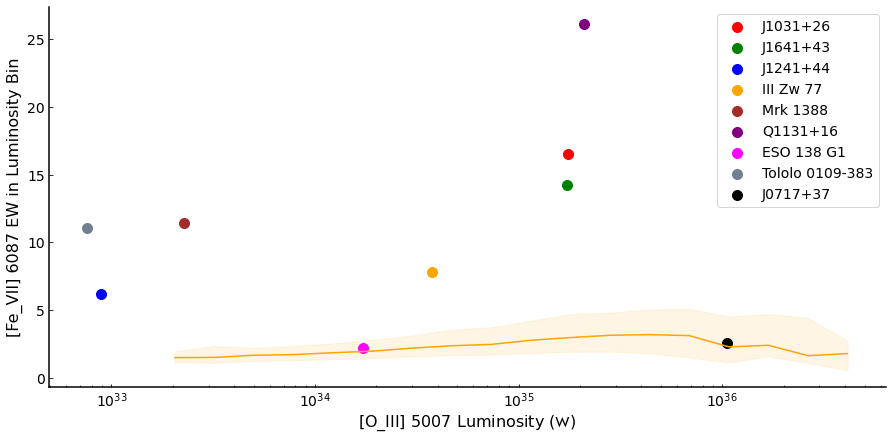

In [122]:
fig, ax = plt.subplots(1, figsize = (15, 7))
ax.set_xscale('log')
ax.plot(plot_centers, plot_values_fe, color='orange')
ax.fill_between(plot_centers, plot_values_fe_lo, plot_values_fe_hi, alpha=.1, color='orange')

for i in range(len(df_CLIF)):
    
    obj_name = df_CLIF.loc[i]['Common Name']
    
    x = df_CLIF.loc[i]['[O_III] 5007 Luminosity']
    y = df_CLIF.loc[i]['[Fe_VII] 6087 EW']
    
    if(np.isnan(y)==False):
        ax.scatter(x, y, label=obj_name, s=100, c=colors[i])

ax.set_xlabel('[O_III] 5007 Luminosity ($W$)')
ax.set_ylabel('[Fe_VII] 6087 EW in Luminosity Bin')
ax.legend()

plt.savefig('Figures/diagnostic_8b.pdf', dpi=300, bbox_inches='tight')

In [123]:
df_CLIF

,Common Name,Object,RA,Dec,z,H_alpha Flux,H_alpha EW,H_beta Flux,H_beta EW,[O_III] 5007 Flux,...,2-10 keV Flux,D_L,[O_III] 5007 Luminosity,2-10 keV Luminosity,[Ne_V] 3425 Detection,[Fe_VII] 5721 Detection,[Fe_VII] 6087 Detection,[Ne_V] 3425 Delta_Flux,[Fe_VII] 5721 Delta_Flux,[Fe_VII] 6087 Delta_Flux
0,J1031+26,spec-6457-56330-0414,"hms_tuple(h=10.0, m=31.0, s=9.53520000000566)","dms_tuple(d=26.0, m=15.0, s=34.02359999999476)",0.252290,766.9597,148.692550,95.23881,18.102041,893.02277,...,NaN,3.937636e+25,1.739977e+35,NaN,2.0,2.0,2.0,4.490112,1.799107,2.150870
1,J1641+43,spec-0628-52083-0526,"hms_tuple(h=16.0, m=41.0, s=26.911200000008648)","dms_tuple(d=43.0, m=21.0, s=21.610800000004247)",0.221039,1215.8800,166.000000,226.00000,35.000000,1200.06000,...,NaN,3.391578e+25,1.734668e+35,NaN,2.0,2.0,2.0,12.697600,3.702481,9.353860
2,J1241+44,spec-1372-53062-0072,"hms_tuple(h=12.0, m=41.0, s=34.252800000005266)","dms_tuple(d=44.0, m=26.0, s=39.24240000000566)",0.041901,315.4560,30.500000,49.60000,5.100000,215.26400,...,NaN,5.740076e+24,8.912849e+32,NaN,0.0,2.0,2.0,NaN,7.297894,4.843313
3,III Zw 77,spec-1171-52753-0076,"hms_tuple(h=16.0, m=23.0, s=45.88560000001081)","dms_tuple(d=41.0, m=4.0, s=56.39879999999437)",0.033103,10458.0000,81.500000,2520.00000,15.400000,14666.40000,...,40000.0,4.506138e+24,3.742332e+34,1.020654e+35,0.0,2.0,2.0,NaN,23.479579,16.104909
4,Mrk 1388,spec-2144-53770-0491,"hms_tuple(h=14.0, m=50.0, s=37.852800000010944)","dms_tuple(d=22.0, m=44.0, s=3.613200000000063)",0.020954,1046.7500,121.100000,265.00000,30.800000,2271.05000,...,2500.0,2.827117e+24,2.280994e+33,2.510947e+33,0.0,2.0,2.0,NaN,34.958424,20.174544
5,Q1131+16,NaN,"hms_tuple(h=11.0, m=31.0, s=11.05)","dms_tuple(d=16.0, m=27.0, s=39.50)",0.173200,2368.5780,296.072250,474.00000,59.250000,2497.98000,...,NaN,2.585353e+25,2.098159e+35,NaN,2.0,2.0,2.0,0.000498,0.000151,0.000235
6,ESO 138 G1,NaN,"hms_tuple(h=16.0, m=51.0, s=20.13)","dms_tuple(d=-59.0, m=14.0, s=05.20)",0.009100,43775.0000,35.088787,10300.00000,8.240000,92700.00000,...,180000.0,1.216924e+24,1.725110e+34,3.349728e+34,2.0,2.0,2.0,0.018500,0.001257,0.002470
7,Tololo 0109-383,NaN,"hms_tuple(h=01.0, m=11.0, s=27.63)","dms_tuple(d=-38.0, m=05.0, s=00.48)",0.011800,28204.0000,154.693395,6440.00000,58.915497,2405.60000,...,120000.0,1.581197e+24,7.557967e+32,3.770186e+34,2.0,2.0,2.0,0.003650,0.000832,0.001790
8,J0717+37,NaN,"hms_tuple(h=07.0, m=17.0, s=35.00)","dms_tuple(d=-37.0, m=45.0, s=42.00)",1.688000,NaN,NaN,4.16000,3.700000,55.86000,...,1000.0,3.867337e+26,1.049868e+36,1.879464e+37,2.0,2.0,2.0,0.000008,0.000002,0.000003


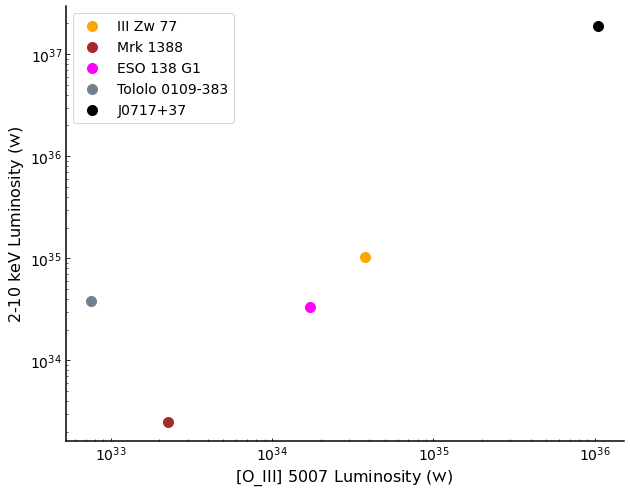

In [124]:
fig, ax = plt.subplots(1, figsize = (10, 8))
ax.set_xscale('log')
ax.set_yscale('log')

for i in range(len(df_CLIF)):
    
    obj_name = df_CLIF.loc[i]['Common Name']
    
    x = df_CLIF.loc[i]['[O_III] 5007 Luminosity']
    y = df_CLIF.loc[i]['2-10 keV Luminosity']
    
    if(np.isnan(y)==False):
        ax.scatter(x, y, label=obj_name, s=100, c=colors[i])

ax.set_xlabel('[O_III] 5007 Luminosity ($W$)')
ax.set_ylabel('2-10 keV Luminosity ($W$)')
ax.legend()

plt.savefig('Figures/diagnostic_9.pdf', dpi=300, bbox_inches='tight')